In [1]:
from platform import python_version

print(python_version())

3.7.9


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from anndata import AnnData

In [3]:
import scanpy as sc
sc.settings.verbosity = 3    

import sys
sys.path.insert(0, "../../SpaGE")
from SpaGE.main import SpaGE

%matplotlib inline

In [4]:
# Set random seed
np.random.seed(42)

## Load scRNA-seq data

##### Load scRNA-seq metadata

In [5]:
sc_ann_df = pd.read_csv('../data/all_cells_meta_data_filtered_formatted.tsv', sep='\t', index_col=0)
sc_ann_df = sc_ann_df.dropna(subset=['nUMI'])
sc_ann_df.head()

nGene   nUMI experiment Phase  res.0.7  \
AAACCTGAGAAACCAT.1    534   1106      Exp_1    G1       11   
AAACCTGGTGGTACAG.1   4294  17447      Exp_1     S        3   
AAACGGGAGATGTAAC.1   1933   4913      Exp_1    G1        2   
AAACGGGAGGCAGTCA.1   2622   7898      Exp_1    G1        2   
AAACGGGAGGTCATCT.1   2682   7731      Exp_1    G1        5   

                                                             celltype    state  
AAACCTGAGAAACCAT.1                                       Erythrocytes  Singlet  
AAACCTGGTGGTACAG.1                           Epicardium-derived cells  Singlet  
AAACGGGAGATGTAAC.1  Fibroblast-like (related to cardiac skeleton c...  Singlet  
AAACGGGAGGCAGTCA.1  Fibroblast-like (related to cardiac skeleton c...  Singlet  
AAACGGGAGGTCATCT.1             Smooth muscle cells / fibroblast-like)  Singlet

##### Load filtered scRNA-seq gene expression data

In [6]:
adata_sc = sc.read_csv(
    '../data/all_cells_count_matrix_filtered.tsv',  # the directory with the `.mtx` file
    delimiter='\t',
    first_column_names=True                # use gene symbols for the variable names (variables-axis index)
    ).T

adata_sc.obs = sc_ann_df

# Normalize data
sc.pp.normalize_total(adata_sc, target_sum=1e6)
sc.pp.log1p(adata_sc)

adata_sc.shape

normalizing counts per cell
    finished (0:00:00)


(3777, 15323)

## Load spage2vec data

In [7]:
adata_sp = sc.read('../results/anndata_pcw6.h5')
adata_sp.shape

(795933, 32)

#### Create psuedo-cellular expression profiles dataframe from spage2vec embedding
This might take some time...you can load directly the neighborhood expression data few cells below

In [8]:
gene_list = np.sort(adata_sp.obs.gene.astype('str').unique())

In [ ]:
# Compute neighbors in spage2vec latent space
sc.pp.neighbors(adata_sp, n_neighbors=100, n_pcs=0)

computing neighbors


In [ ]:
# Create pseudo-cellular expression dataframe
r_idx, nn_idx = adata_sp.obsp['connectivities'].nonzero()
df_sp_nn = pd.DataFrame(np.zeros((adata_sp.shape[0], gene_list.shape[0])), columns = gene_list)
r_idx_sub = r_idx

for r in tqdm(np.unique(r_idx_sub)):
    df_tmp = adata_sp.obs.iloc[nn_idx[np.where(r_idx==r)[0]],0].value_counts()
    df_tmp = df_tmp[df_tmp!=0]
    df_tmp_idx = df_tmp[df_tmp!=0].index.values
    df_tmp_v = df_tmp[df_tmp!=0].values
    
    df_sp_nn.loc[r,df_tmp_idx] = df_tmp_v
    
adata_sp_nn = AnnData(df_sp_nn.values, obs = adata_sp.obs.iloc[np.unique(r_idx_sub)])
adata_sp_nn.var_names = df_sp_nn.columns

In [12]:
# Save dataframe
adata_sp_nn.write('../results/adata_sp_nn_pcw6.h5')

##### Load pseudo-cellular expression data

In [8]:
adata_sp_nn = sc.read('../results/adata_sp_nn_pcw6.h5')

# Filter zero genes
sc.pp.filter_genes(adata_sp_nn, min_counts=100)

# Normalize data
sc.pp.normalize_total(adata_sp_nn)
sc.pp.log1p(adata_sp_nn)

normalizing counts per cell
    finished (0:00:00)


#### Extract spatial and scRNAseq data and gene list

In [139]:
sp_df = adata_sp_nn.to_df().copy()
sc_df = adata_sc.to_df().copy()
gene_list = adata_sp_nn.var_names

## Spage2vec and scRNA-seq data integration

#### For each scRNAseq cell find the 100 closests spatial pseudo-cellular profiles from which infer spage2vec cluster labels based on cosine similarities
You can skip the computation and load directly the dataframe few cells below

In [ ]:
from SpaGE.principal_vectors import PVComputation
from sklearn.neighbors import NearestNeighbors

genes_to_predict = np.setdiff1d(sc_df.columns,sp_df.columns)
n_pv = 30

RNA_data_scaled = pd.DataFrame(data=st.zscore(sc_df,axis=0),
                               index = sc_df.index,columns=sc_df.columns)
Spatial_data_scaled = pd.DataFrame(data=st.zscore(sp_df,axis=0),
                               index = sp_df.index,columns=sp_df.columns)
Common_data = Spatial_data_scaled[np.intersect1d(Spatial_data_scaled.columns,RNA_data_scaled.columns)]


pv_SC_RNA = PVComputation(
        n_factors = n_pv,
        n_pv = n_pv,
        dim_reduction = 'pca',
        dim_reduction_target = 'pca'
)

pv_SC_RNA.fit(Common_data,RNA_data_scaled[Common_data.columns])

S = pv_SC_RNA.source_components_.T

Effective_n_pv = sum(np.diag(pv_SC_RNA.cosine_similarity_matrix_) > 0.3)
S = S[:,0:Effective_n_pv]

Common_data_t = Common_data.dot(S)
SC_exp_t = RNA_data_scaled[Common_data.columns].dot(S)

nbrs = NearestNeighbors(n_neighbors=100, algorithm='auto',
                        metric = 'cosine').fit(Common_data_t)
distances, indices = nbrs.kneighbors(SC_exp_t)

In [ ]:
# Create dataframe of cosine similarities between scRNAseq data and spage2vec clusters 
sc_cluster_df = pd.DataFrame(np.zeros((sc_df.shape[0],len(adata_sp_nn.obs.leiden_m1.unique()))), index=sc_df.index, columns=np.arange(len(adata_sp_nn.obs.leiden_m1.unique())))
for j in tqdm(range(0,sc_df.shape[0])):
    weights = 1-(distances[j,:][distances[j,:]<1])#/(np.sum(distances[j,:][distances[j,:]<1]))
    weights = weights/(len(weights)-1)
    for c in adata_sp_nn.obs.iloc[indices[j,:],:].leiden_m1.unique():
        c_idx = np.where(adata_sp_nn.obs.iloc[indices[j,:],:].leiden_m1.values==c)[0]
        sc_cluster_df.iloc[j,int(c)] = np.sum(weights[c_idx])

In [ ]:
# Filter scRNA-seq cells with low correpondence with spatial data (low cosine similarity)
sc_cluster_df = sc_cluster_df[sc_cluster_df.max(axis=1) > 0.3]

In [23]:
# Save dataframe
sc_cluster_df.to_pickle('../results/sc_cluster_df_pcw6.h5')

#### Load dataframe of cosine similarities

In [9]:
# Load dataframe
sc_cluster_df = pd.read_pickle('../results/sc_cluster_df_pcw6.h5')

In [10]:
# Assign spage2vec cluster labels to scRNA-seq data (selecting the cluster label showing highest cosine similarity)
adata_sc.obs.loc[sc_cluster_df.idxmax(1).index, 'leiden_m1'] = sc_cluster_df.idxmax(1).values
adata_sc.obs["leiden_m1"] = adata_sc.obs["leiden_m1"].astype('category')

In [11]:
# Filter scRNA-seq cells with low correpondence with spatial data in the original AnnData object 
adata_sc_tmp = adata_sc[sc_cluster_df.index,:].copy()
adata_sc_tmp.obs = adata_sc_tmp.obs.rename(columns={'res.0.7':'cluster'})
adata_sc_tmp

AnnData object with n_obs × n_vars = 3237 × 15323
    obs: 'nGene', 'nUMI', 'experiment', 'Phase', 'cluster', 'celltype', 'state', 'leiden_m1'
    uns: 'log1p'

In [12]:
# Select spage2vec cluster with less than 10 scRNAseq cells associated
cls = adata_sc_tmp.obs["leiden_m1"].value_counts()[adata_sc_tmp.obs["leiden_m1"].value_counts()>=10].index
print('spage2vec cluster \t num. cells')
print(adata_sc_tmp.obs["leiden_m1"].value_counts())

spage2vec cluster 	 num. cells
12.0    377
9.0     348
14.0    336
4.0     325
17.0    285
10.0    178
20.0    172
18.0    124
8.0     114
26.0    113
6.0     111
0.0      98
11.0     78
28.0     57
7.0      54
21.0     53
2.0      53
1.0      49
5.0      49
15.0     46
23.0     46
29.0     34
3.0      33
25.0     27
22.0     23
19.0     18
27.0     15
13.0     12
16.0      7
24.0      2
Name: leiden_m1, dtype: int64


#### Plot heatmap of cosine similarities between scRNAseq-data and spage2vec clusters

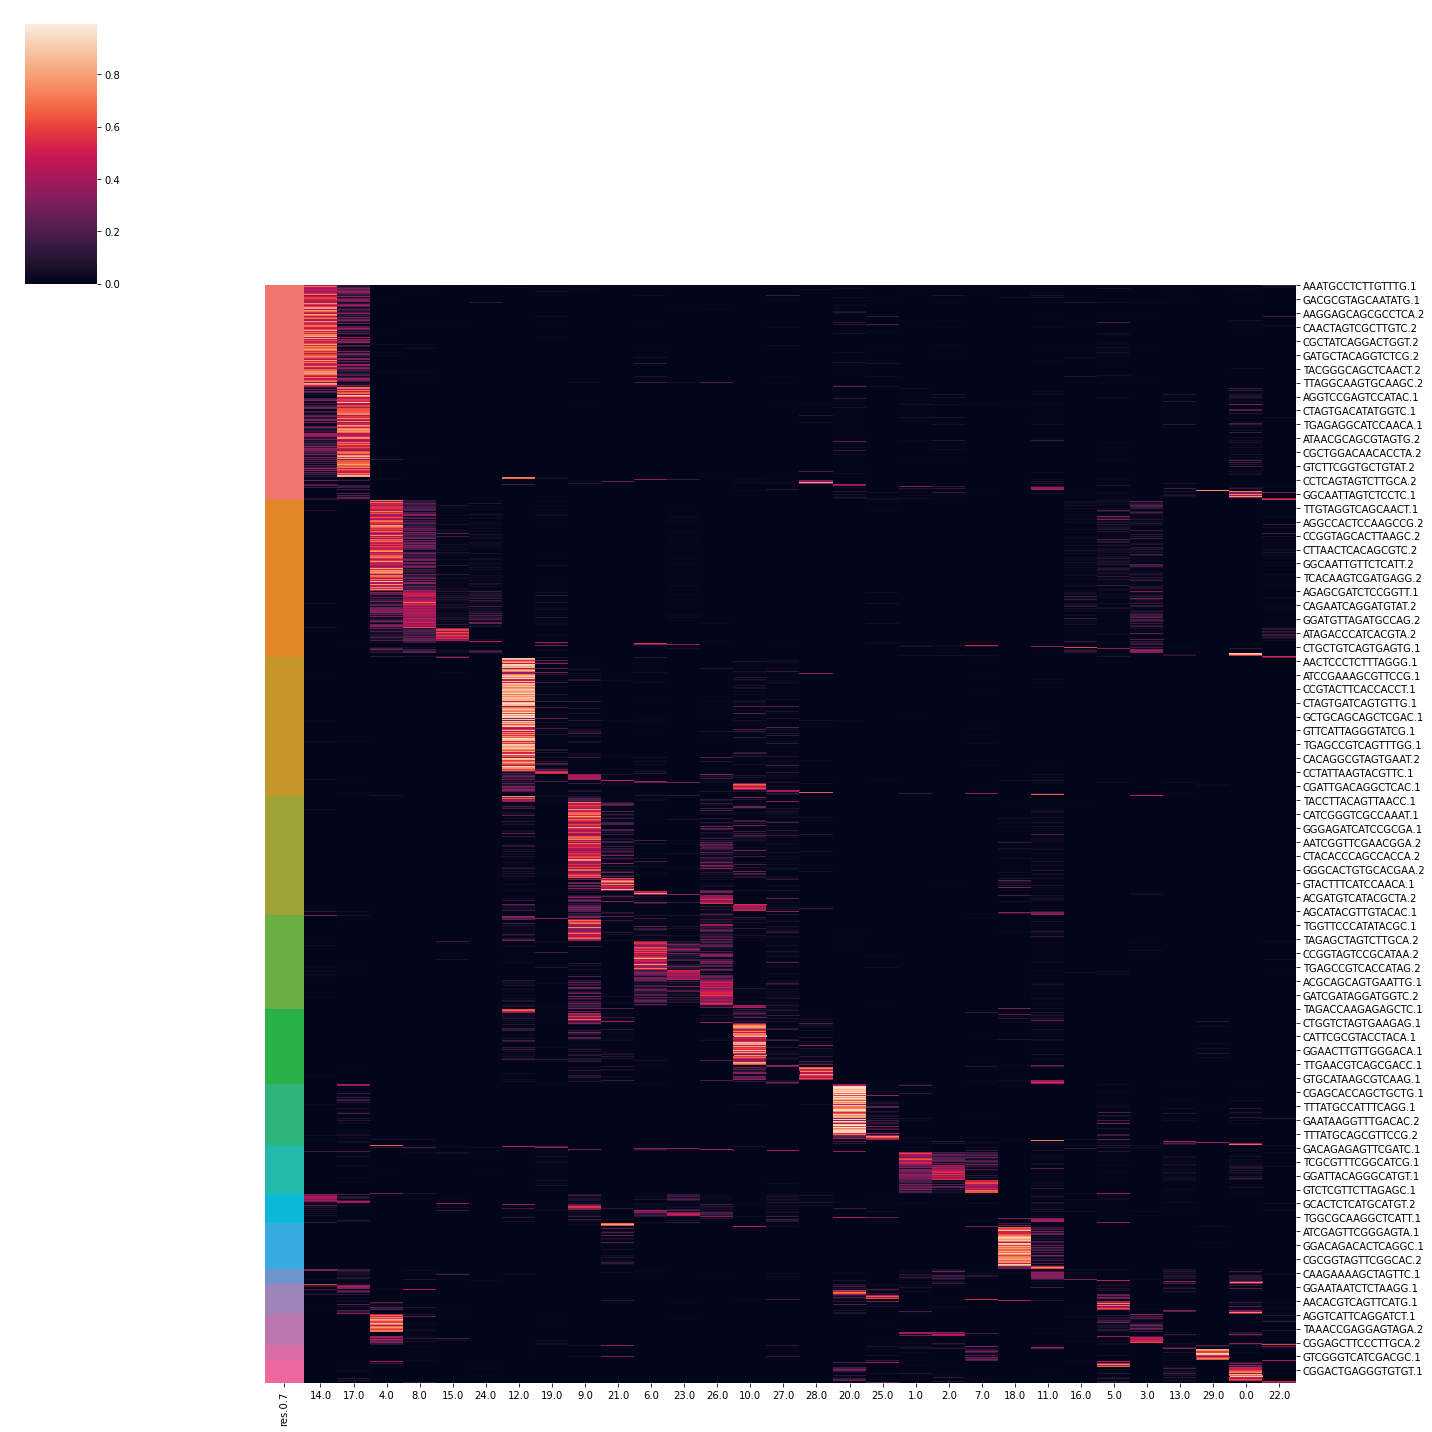

In [13]:
# Create dictionary of spage2vec - scRNA-seq cluster correspondece
sc_c_idx = [adata_sc_tmp.obs[adata_sc_tmp.obs.leiden_m1==x].loc[:,'cluster'].value_counts().idxmax() for x in np.sort(adata_sc_tmp.obs.leiden_m1.unique())]
sc_c_v = [adata_sc_tmp.obs[adata_sc_tmp.obs.leiden_m1==x].loc[:,'cluster'].value_counts().max() for x in np.sort(adata_sc_tmp.obs.leiden_m1.unique())]

d = dict(zip(np.sort(adata_sc_tmp.obs.leiden_m1.unique()), sc_c_idx))

# col ordering
col_order = list({k: v for k, v in sorted(d.items(), key=lambda item: item[1])}.keys())

# row ordering
new_idx = []
for c in np.sort(adata_sc_tmp.obs.cluster.unique()):
    for sp_c in col_order:
        new_idx.append(adata_sc_tmp[(adata_sc_tmp.obs.cluster==c) & (adata_sc_tmp.obs.leiden_m1 == sp_c)].obs.index.values)
    
new_idx = np.concatenate(new_idx)


ct_color_d = {0: '#F0756D',
            1: '#E18725',
            2: '#C5972B',
            3: '#9EA237',
            4: '#6AAF43',
            5: '#29B14A',
            6: '#30B47B',
            7: '#23B9AA',
            8: '#0AB9D6',
            9: '#37AADF',
            10: '#6F93CA',
            11: '#9D84BB',
            12: '#BB76B0',
            13: '#D96DA8',
            14: '#EE669E'}

row_colors = adata_sc.obs.loc[new_idx,'res.0.7'].map(ct_color_d)

sns.clustermap(sc_cluster_df.loc[new_idx,col_order],col_cluster=False, row_cluster=False,metric='cosine', method='ward', figsize=(20,20), row_colors= row_colors)

In [14]:
# Filter spage2vec cluster with less than 10 scRNAseq cells associated
adata_sc_tmp = adata_sc_tmp[adata_sc_tmp.obs.leiden_m1.isin(cls)].copy()
adata_sc_tmp

AnnData object with n_obs × n_vars = 3228 × 15323
    obs: 'nGene', 'nUMI', 'experiment', 'Phase', 'cluster', 'celltype', 'state', 'leiden_m1'
    uns: 'log1p'

## Plot back clusters in tissue

In [14]:
coldict=dict(zip(np.unique(adata_sp.obs['leiden_m1']),adata_sp.uns['leiden_m1_colors']))

Note that colors are extracted manually from the ones used in the PAGA PLOT PCW6 (FIG2A)

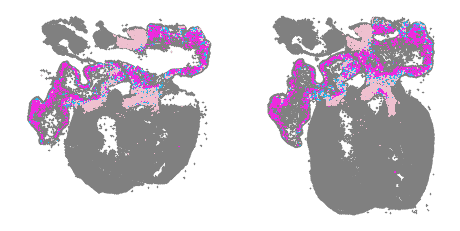

In [17]:
clusters=np.unique(adata_sp.obs.leiden_m1)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 4))
plt.scatter(x=adata_sp.obs.spotX/5,y=-adata_sp.obs.spotY/5,c='#808080',s=1.5,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='1']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='1']/5,c='#29BCF0',s=1,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='2']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='2']/5,c='#F029DF',s=1,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='7']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='7']/5,c='#F0C1D0',s=1,linewidths=0, edgecolors=None)
plt.axis('off')

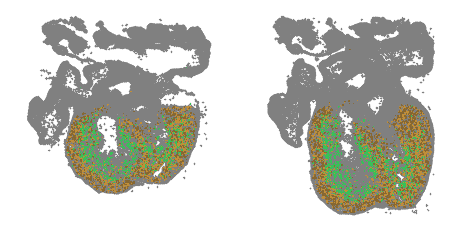

In [50]:
clusters=np.unique(adata_sp.obs.leiden_m1)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 4))
plt.scatter(x=adata_sp.obs.spotX/5,y=-adata_sp.obs.spotY/5,c='#808080',s=1.5,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='4']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='4']/5,c='#38c258',s=1,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='8']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='8']/5,c='#c28f38',s=1,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='15']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='15']/5,c='#876731',s=1,linewidths=0, edgecolors=None)
plt.axis('off')

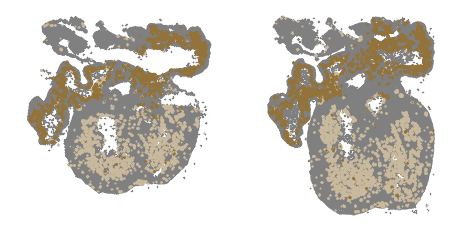

In [52]:
clusters=np.unique(adata_sp.obs.leiden_m1)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 4))
plt.scatter(x=adata_sp.obs.spotX/5,y=-adata_sp.obs.spotY/5,c='#808080',s=1.5,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='14']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='14']/5,c='#c9b99d',s=4,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='17']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='17']/5,c='#94733a',s=4,linewidths=0, edgecolors=None)
plt.axis('off')

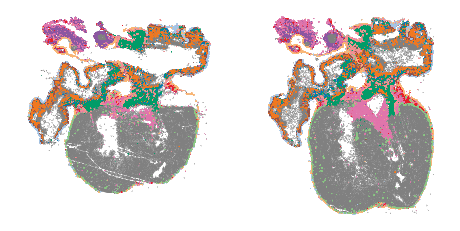

In [25]:
clusters=np.unique(adata_sp.obs.leiden_m1)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 4))
plt.scatter(x=adata_sp.obs.spotX/5,y=-adata_sp.obs.spotY/5,c='#808080',s=0.1,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='1']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='1']/5,c='#0178B6',s=0.4,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='2']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='2']/5,c='#F47820',s=0.4,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='7']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='7']/5,c='#009F68',s=0.4,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='9']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='9']/5,c='#E91D28',s=0.4,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='10']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='10']/5,c='#8D58A4',s=0.4,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='11']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='11']/5,c='#96544B',s=0.4,linewidths=0, edgecolors=None)

plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='12']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='12']/5,c='#E376AE',s=0.4,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='18']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='18']/5,c='#A7C8E9',s=0.4,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='21']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='21']/5,c='#FCB877',s=0.4,linewidths=0, edgecolors=None)
            
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='26']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='26']/5,c='#8BCA85',s=0.4,linewidths=0, edgecolors=None)
plt.scatter(x=adata_sp.obs.spotX[adata_sp.obs.leiden_m1=='27']/5,y=-adata_sp.obs.spotY[adata_sp.obs.leiden_m1=='27']/5,c='#F59395',s=0.4,linewidths=0, edgecolors=None)


plt.axis('off')

# Calculate DE genes

In [15]:
adata_sc_tmp.obs["leiden_m1"] = adata_sc_tmp.obs["leiden_m1"].astype(int).astype("category")
sc.tl.rank_genes_groups(adata_sc_tmp, groupby='leiden_m1',method='t-test')

ranking genes


... storing 'experiment' as categorical
... storing 'Phase' as categorical
... storing 'celltype' as categorical
... storing 'state' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


#### Rank differentially expressed genes in scRNA-seq data between spage2vec clusters

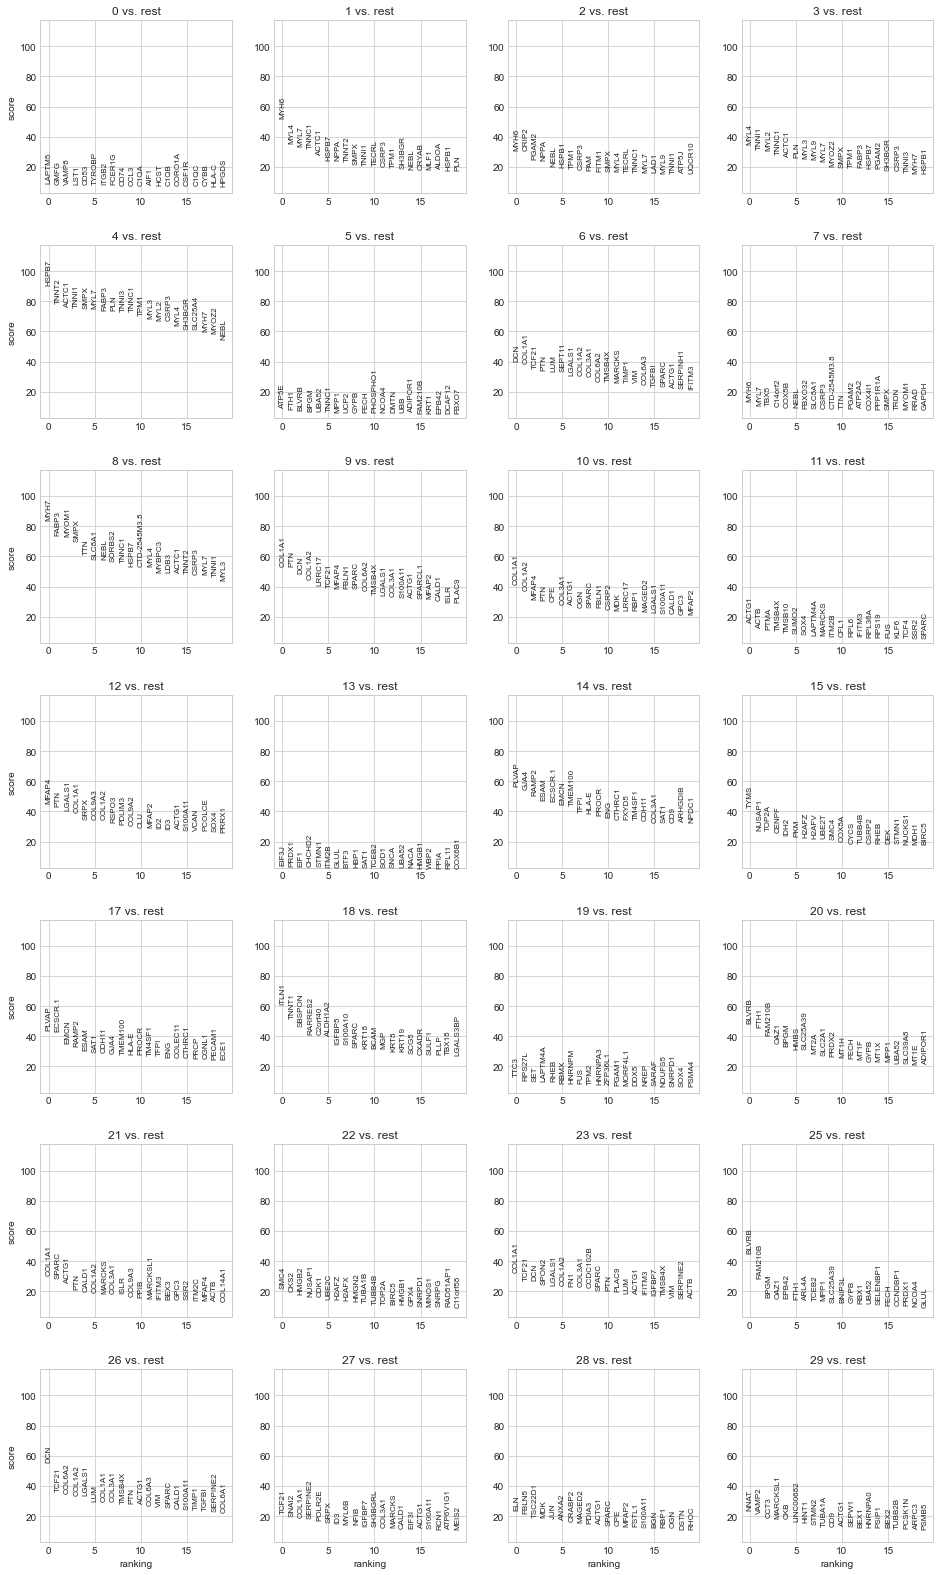

In [53]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 4,4
sc.pl.rank_genes_groups(adata_sc_tmp, values_to_plot='scores')

#### Dotplot of marker genes for spage2vec clusters

computing PCA
    with n_comps=50
    finished (0:00:02)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_m1']`


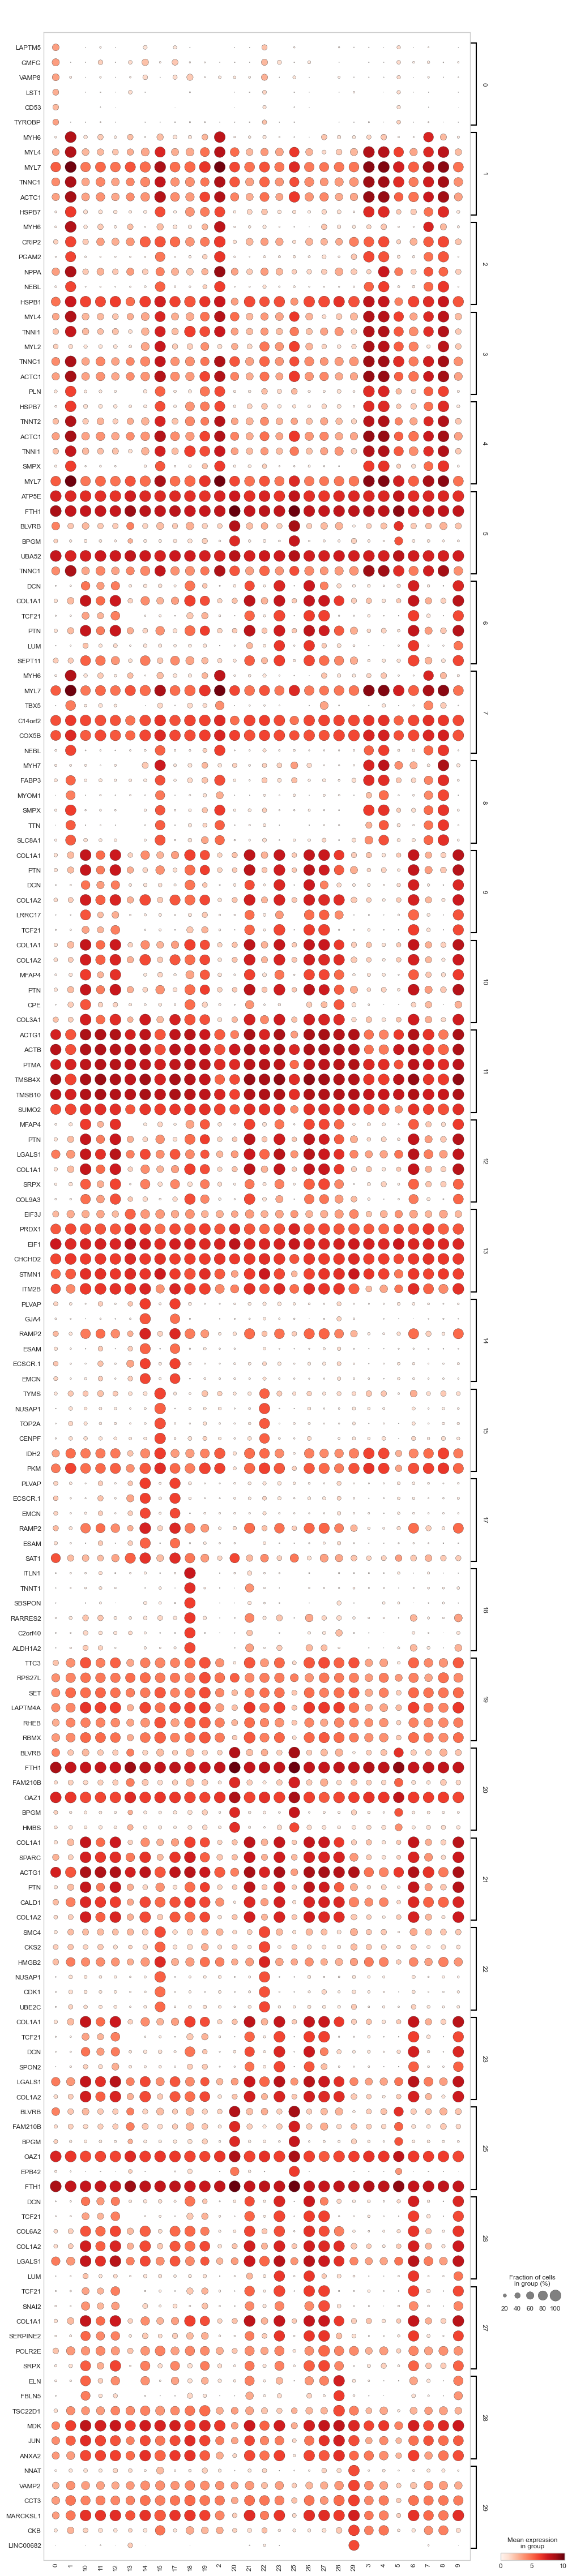

In [62]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 7,7
rcParams['figure.dpi']=100

adata_sc_tmp.obs["leiden_m1"] = adata_sc_tmp.obs["leiden_m1"].astype(str)
adata_sc_tmp.obs.leiden_m1 = adata_sc_tmp.obs.leiden_m1.astype("category")
sc.pp.pca(adata_sc_tmp, 50)
sc.tl.dendrogram(adata_sc_tmp, groupby='leiden_m1', cor_method='spearman', linkage_method='average')

sc.pl.rank_genes_groups_dotplot(adata_sc_tmp, n_genes=6, dendrogram=False, save='.pdf',swap_axes=True)

##### DiffusionMap on spatial pseudo-cellular profiles (start cluster 18 - Epicardial)

In [34]:
c_list = ['1', '2', '7', # Atrial CM
          '9', '12', '21', '26', # Fibroblast-like/EPDC
          '18', '11', '27', # Epicardial
           # Endothelial
          '10',  #VLMC
         ]
ad = adata_sp[adata_sp.obs.leiden_m1.isin(c_list)].copy()

In [35]:
# Diffusion pseudotime analysis on spage2vec
sc.pp.neighbors(ad, n_neighbors=50, use_rep='X')
sc.tl.diffmap(ad)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:04:56)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:02)
    eigenvalues of transition matrix
    [1.         0.99912983 0.99684346 0.9953856  0.9917446  0.9888424
     0.9877067  0.98686194 0.985163   0.98220575 0.9793999  0.97794926
     0.9770458  0.9757796  0.9745227 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:58)


In [43]:
ad.uns['iroot'] = np.flatnonzero(ad.obs['leiden_m1'] == '18')[300]
sc.tl.dpt(ad, n_branchings=0, n_dcs=15)

computing Diffusion Pseudotime using n_dcs=15
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [71]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=700)

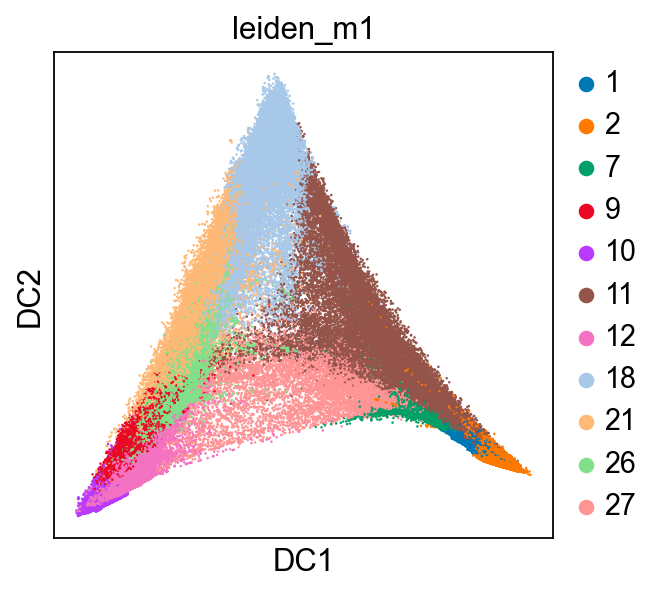

In [39]:
pal = ['#0078B5',
'#FF7900',
'#00A068',
'#EA0924',
'#B83BFD',
'#95544A',
'#F472C2',
'#A7C8E9',
'#FFB976',
'#81E089',
'#FF9495',
'#C9AFD5']
sc.pl.diffmap(ad, color=['leiden_m1'], size=5, projection='2d', palette=pal)

In [54]:
ad.uns['iroot'] = np.flatnonzero(ad.obs['leiden_m1'] == '18')[300]
sc.tl.dpt(ad, n_branchings=0, n_dcs=15)

computing Diffusion Pseudotime using n_dcs=15
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [57]:
ad.obs.dpt_pseudotime[ad.obs.dpt_pseudotime>0.5]=0.5

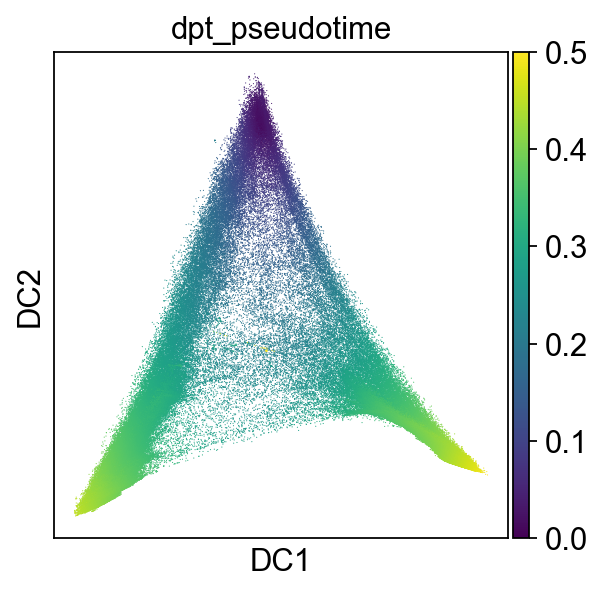

In [72]:
fig=sc.pl.diffmap(ad, color=['dpt_pseudotime'], size=1, projection='2d', palette=pal,save='Spage2vec_heart_pseudotimePCW6_pseudo3.pdf',return_fig=True)

In [90]:
ad2=ad[ad.obs.leiden_m1.isin(['18','11','1','2','7'])]

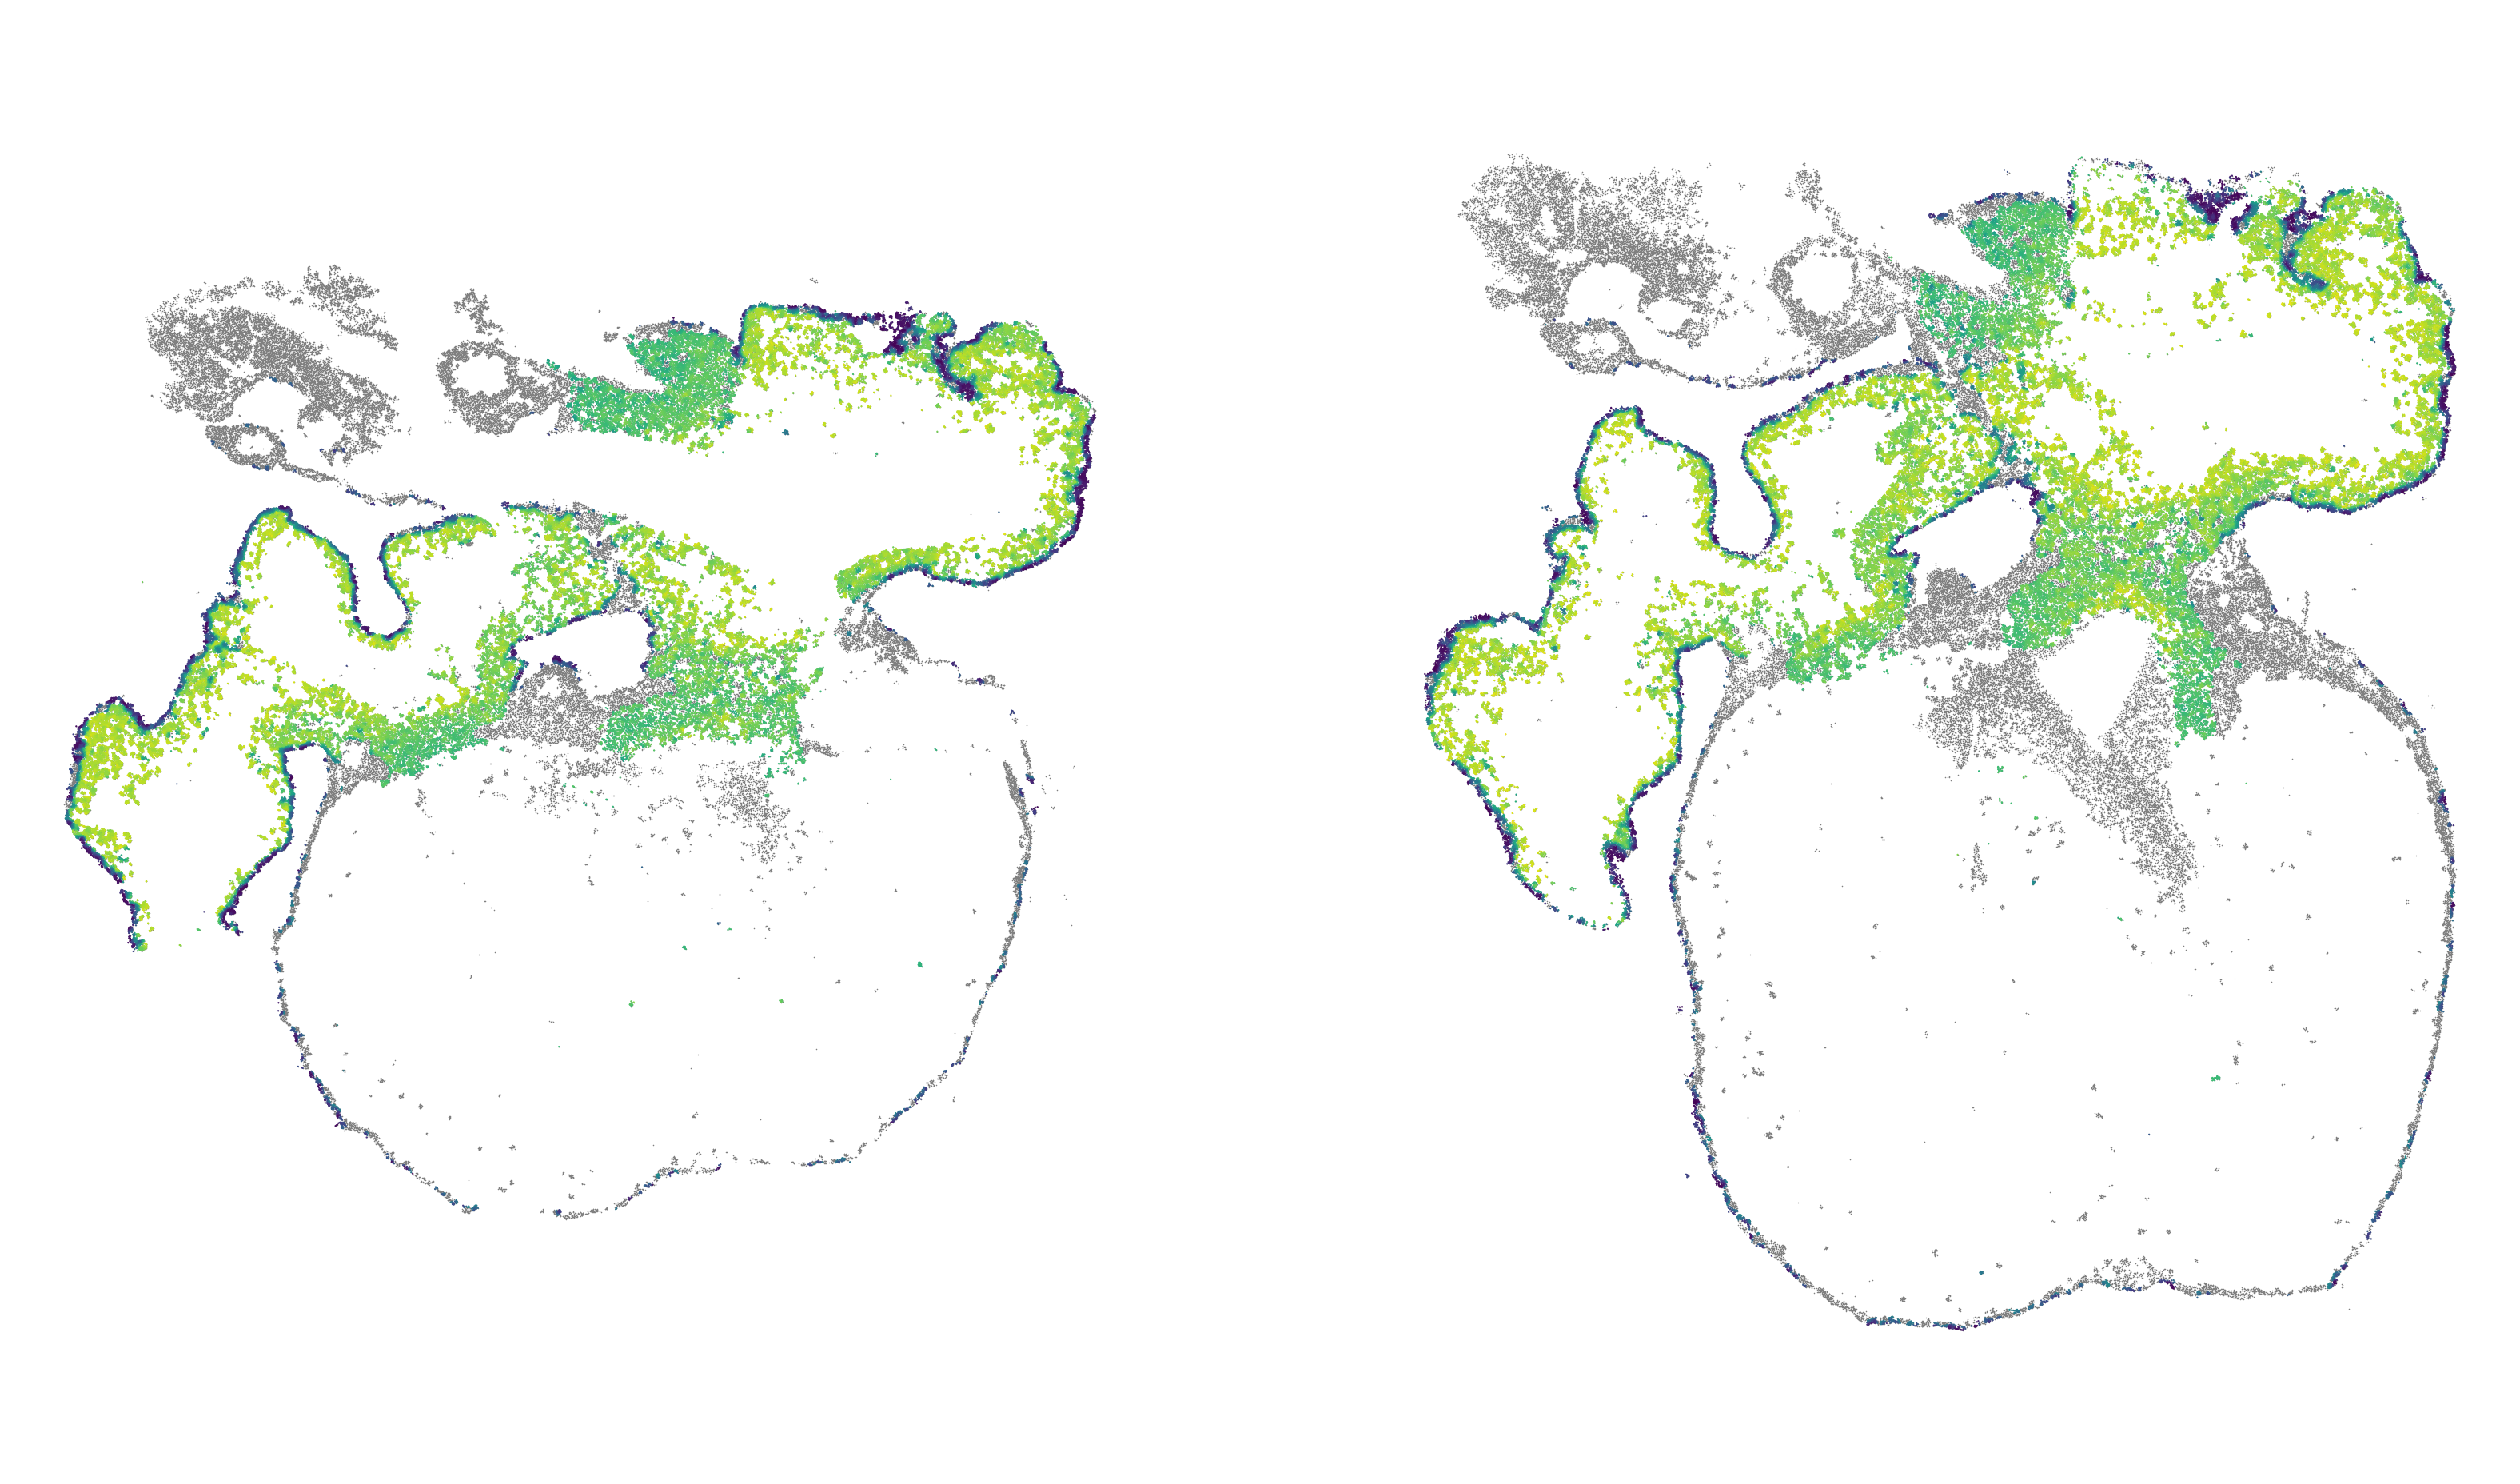

In [91]:
plt.figure(figsize=(25,15))
for i in range(1,3,1):
    plt.subplot(1,2,i)
    plt.scatter(x=ad[ad.obs.section==i].obs.spotX,y=-ad[ad.obs.section==i].obs.spotY,c='#808080',s=0.5,linewidths=0, edgecolors=None)
    plt.scatter(ad2[ad2.obs.section==i].obs.spotX, -ad2[ad2.obs.section==i].obs.spotY, c=ad2[ad2.obs.section==i].obs.dpt_pseudotime, linewidths=0, s=1)
    plt.axis("equal")
    plt.axis('off')

In [78]:
ad2=ad[ad.obs.leiden_m1.isin(['10','9','21','18'])]

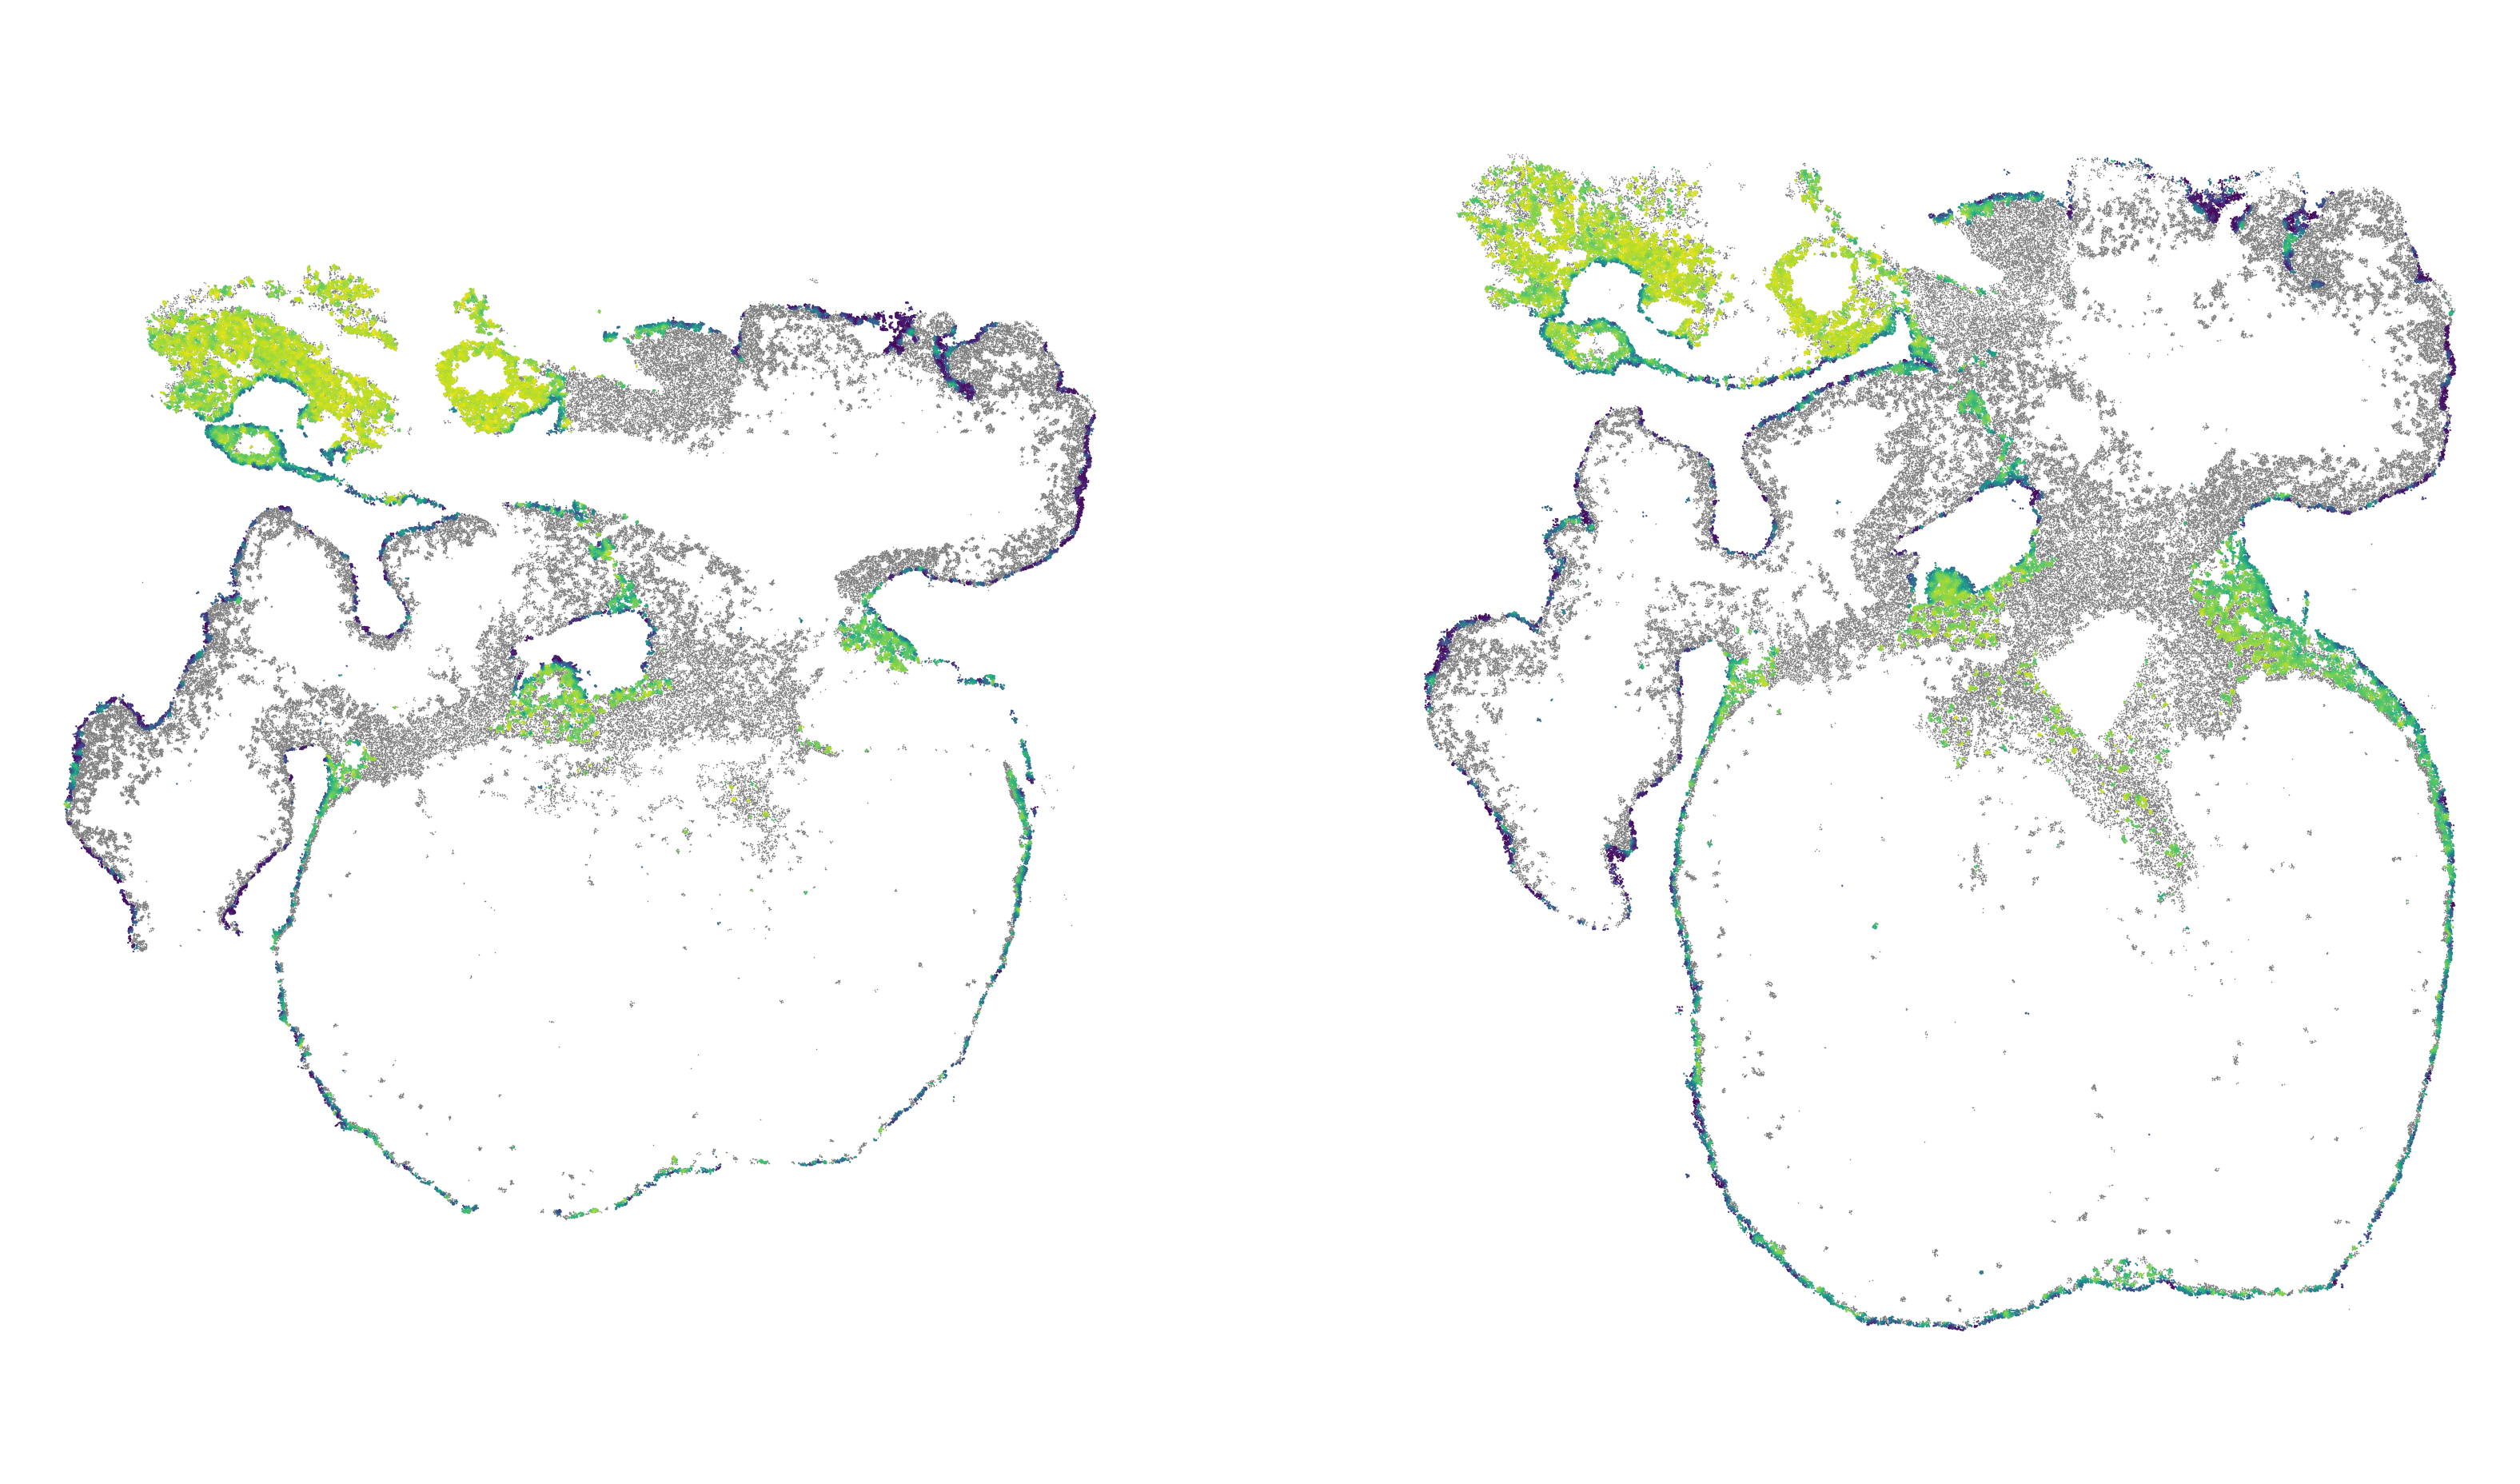

In [89]:
plt.figure(figsize=(25,15))
for i in range(1,3,1):
    plt.subplot(1,2,i)
    plt.scatter(x=ad[ad.obs.section==i].obs.spotX,y=-ad[ad.obs.section==i].obs.spotY,c='#808080',s=0.5,linewidths=0, edgecolors=None)
    plt.scatter(ad2[ad2.obs.section==i].obs.spotX, -ad2[ad2.obs.section==i].obs.spotY, c=ad2[ad2.obs.section==i].obs.dpt_pseudotime, linewidths=0, s=1)
    plt.axis("equal")
    plt.axis('off')